In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import accuracy_score, mean_squared_error , r2_score , mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR

In [2]:
df=pd.read_csv("Breast_Cancer.csv")

data3=df.copy()

for index, satir in data3.iterrows():
    if isinstance(satir['Grade'], str):
        if satir['Grade'] == ' anaplastic; Grade IV':
            data3.at[index, 'Grade'] = '4'

data3['Grade'] = data3['Grade'].astype(int)
data3["Grade"].unique()

label_encoder = LabelEncoder()

data3['T Stage'] = label_encoder.fit_transform(data3['T Stage '])
data3['N Stage'] = label_encoder.fit_transform(data3['N Stage'])
data3['6th Stage'] = label_encoder.fit_transform(data3['6th Stage'])

data3.drop(["Status", "T Stage "], axis=1, inplace=True)

data_encoded = pd.get_dummies(data3, columns=['Race', 'Marital Status', 'A Stage', 'Estrogen Status', 'Progesterone Status','differentiate'], dtype=int)

data_encoded.rename(columns={'Marital Status_Separated': 'Separated',
                   'Marital Status_Married': 'Married',
                   'Marital Status_Single ': 'Single',
                   'Marital Status_Widowed':'Widowed',
                   'Marital Status_Divorced':'Divorced',
                   'differentiate_Moderately differentiated':'Moderately',
                   'differentiate_Poorly differentiated':'Poorly',
                   'differentiate_Undifferentiated':'Undifferentiated',
                   'differentiate_Well differentiated':'Well',
                   'Race_Black':'Black',
                   'Race_Other':'Other',
                   'Race_White':'White'
                   }, inplace=True)
data_encoded.drop(["A Stage_Distant", "Single", "Separated", "Widowed", "Divorced", "Black", 
                   "Other", "Moderately", "Undifferentiated", "Well", "Estrogen Status_Negative", "Progesterone Status_Negative"], axis=1, inplace=True)

data_encoded.head()

,Age,N Stage,6th Stage,Grade,Tumor Size,Regional Node Examined,Reginol Node Positive,Survival Months,T Stage,White,Married,A Stage_Regional,Estrogen Status_Positive,Progesterone Status_Positive,Poorly
0,68,0,0,3,4,24,1,60,0,1,1,1,1,1,1
1,50,1,2,2,35,14,5,62,1,1,1,1,1,1,0
2,58,2,4,2,63,14,7,75,2,1,0,1,1,1,0
3,58,0,0,3,18,2,1,84,0,1,1,1,1,1,1
4,47,0,1,3,41,3,1,50,1,1,1,1,1,1,1


In [3]:
data_encoded.columns

Index(['Age', 'N Stage', '6th Stage', 'Grade', 'Tumor Size',
       'Regional Node Examined', 'Reginol Node Positive', 'Survival Months',
       'T Stage', 'White', 'Married', 'A Stage_Regional',
       'Estrogen Status_Positive', 'Progesterone Status_Positive', 'Poorly'],
      dtype='object')

#### Train/Test Split

In [4]:
X = data_encoded.drop('Survival Months', axis=1)
y = data_encoded["Survival Months"]

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### 3-CART

In [6]:
cart_model=DecisionTreeRegressor()

In [7]:
cart_model.fit(X_train, y_train)

DecisionTreeRegressor()

In [8]:
# Tahmin
y_pred=cart_model.predict(X_test)
y_pred[0:5]

array([98., 56., 45., 63., 82.])

In [9]:
# Test Hatamız
np.sqrt(mean_squared_error(y_test, y_pred))

32.02335134016895

In [10]:
# Model Tuning
# hyperparameters
cart_params={"min_samples_split":range(2, 100),
             "max_leaf_nodes":range(2, 10)}

In [11]:
cart_model_tune=GridSearchCV(cart_model, cart_params, cv=10)

In [12]:
cart_model_tune.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=DecisionTreeRegressor(),
             param_grid={'max_leaf_nodes': range(2, 10),
                         'min_samples_split': range(2, 100)})

In [13]:
cart_model_tune.best_params_

{'max_leaf_nodes': 4, 'min_samples_split': 98}

In [14]:
cart_tuned=DecisionTreeRegressor(max_leaf_nodes=4, min_samples_split=98)

In [15]:
cart_tuned.fit(X_train, y_train)

DecisionTreeRegressor(max_leaf_nodes=4, min_samples_split=98)

In [16]:
# Tahmin
y_pred=cart_tuned.predict(X_test)
y_pred[0:5]

array([74.07432432, 74.07432432, 68.0802005 , 68.0802005 , 74.07432432])

In [17]:
# Test Hatamız
np.sqrt(mean_squared_error(y_test, y_pred))

22.66681324296218

##### Evaulation-CART

In [18]:
mae = mean_absolute_error(y_test, y_pred)
print("MAE:", mae)

mse = mean_squared_error(y_test, y_pred)
print("MSE:", mse)

rmse = np.sqrt(mse)
print("RMSE:", rmse)

r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)

def mean_absolute_percentage_error(y_test, y_pred):
    y_test, y_pred = np.array(y_test), np.array(y_pred)
    return np.mean(np.abs((y_test - y_pred) / y_test)) * 100

mape = mean_absolute_percentage_error(y_test, y_pred)
print("MAPE:", mape)

MAE: 18.53584420045488
MSE: 513.7844225913258
RMSE: 22.66681324296218
R-squared: 0.038692464437530716
MAPE: 54.498375588837554


#### 4- SVR (Support Vector Regression)

In [19]:
data_encoded.columns

Index(['Age', 'N Stage', '6th Stage', 'Grade', 'Tumor Size',
       'Regional Node Examined', 'Reginol Node Positive', 'Survival Months',
       'T Stage', 'White', 'Married', 'A Stage_Regional',
       'Estrogen Status_Positive', 'Progesterone Status_Positive', 'Poorly'],
      dtype='object')

In [20]:
X = data_encoded[['Age', 'N Stage', '6th Stage', 'Grade', 'Tumor Size',
       'Regional Node Examined', 'Reginol Node Positive', 'T Stage', 'White', 'Married', 'A Stage_Regional',
       'Estrogen Status_Positive', 'Progesterone Status_Positive', 'Poorly']]
y = data_encoded["Survival Months"]

- SVR aşırı aykırı değerlere karşı hassasiyeti var. Dolayısıyla standartlaşma yapmak zorunda kalıyoruz.

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23)

In [22]:
sc1=StandardScaler()
sc2=StandardScaler()

In [23]:
X_olcekli=sc1.fit_transform(X)

In [24]:
y_olcekli=np.ravel(sc2.fit_transform(y.values.reshape(-1,1)))

In [25]:
svr_reg=SVR(kernel="linear")

In [26]:
svr_reg.fit(X_olcekli, y_olcekli)

SVR(kernel='linear')

In [27]:
y_pred_svr=svr_reg.predict(X_olcekli)

In [28]:
y_olcekli_20=y_olcekli[:20]
y_pred_svr_20=y_pred_svr[:20]

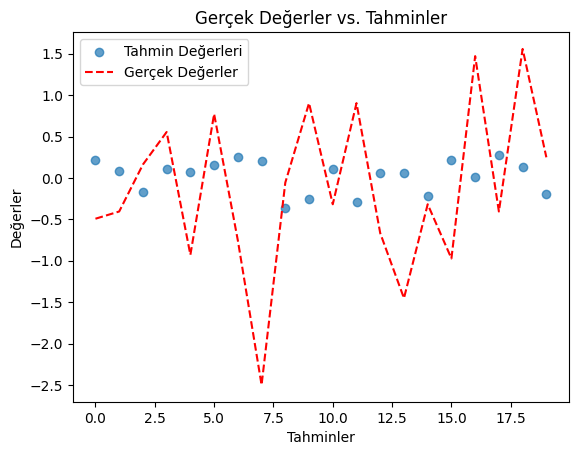

In [29]:
# Scatter plot ile tahmin değerlerini görselleştirme
plt.scatter(range(len(y_olcekli_20)), y_pred_svr_20, label="Tahmin Değerleri", alpha=0.7)

# Gerçek değerleri çizgi olarak görselleştirme
plt.plot(range(len(y_olcekli_20)), y_olcekli_20, color='red', linestyle='--', label="Gerçek Değerler")

plt.xlabel('Tahminler')
plt.ylabel('Değerler')
plt.title('Gerçek Değerler vs. Tahminler')
plt.legend()
plt.show()

#### Evaulation-SVR

In [ ]:
mae = mean_absolute_error(y_olcekli, y_pred_svr)
print("MAE:", mae)

mse = mean_squared_error(y_olcekli, y_pred_svr)
print("MSE:", mse)

rmse = np.sqrt(mse)
print("RMSE:", rmse)

r2 = r2_score(y_olcekli, y_pred_svr)
print("R-squared:", r2)

MAE: 0.8013166131219552
MSE: 0.9630861648516904
RMSE: 0.9813695353187251
R-squared: 0.03691383514830937
MAPE: 123.09667807620701


### 5- Random Forest

In [31]:
X = data_encoded[['Age', 'N Stage', '6th Stage', 'Grade', 'Tumor Size',
       'Regional Node Examined', 'Reginol Node Positive', 'T Stage', 'White', 'Married', 'A Stage_Regional',
       'Estrogen Status_Positive', 'Progesterone Status_Positive', 'Poorly']]
y = data_encoded["Survival Months"]

In [32]:
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.25, random_state=42)

In [33]:
rf_model=RandomForestRegressor(random_state=42)

In [34]:
rf_model.fit(X_train,y_train)

RandomForestRegressor(random_state=42)

In [35]:
rf_model.predict(X_test)[0:5]

array([80.45, 64.52, 75.81, 75.92, 70.04])

In [36]:
y_pred_rf=rf_model.predict(X_test)

In [37]:
np.sqrt(mean_squared_error(y_test, y_pred_rf))

23.399322211023048

##### Model Tune-RF

In [38]:
rf_params={"max_depth":list(range(1, 10)),
           "max_features":[3, 5, 10, 15],
           "n_estimators":[100, 200, 500, 1000, 2000]}

In [39]:
rf_model=RandomForestRegressor(random_state=42)

 Modelin hyperparameter'larını optimize edin. GridSearchCV veya RandomizedSearchCV gibi teknikler kullanılabilir

In [40]:
rf_cv_model=GridSearchCV(rf_model,
                         rf_params,
                         cv=10,
                         n_jobs=-1) # eş zamanlı yapılacak işlemleride devreye alır

In [42]:
rf_cv_model.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9],
                         'max_features': [3, 5, 10, 15],
                         'n_estimators': [100, 200, 500, 1000, 2000]})

In [43]:
rf_cv_model.best_params_

{'max_depth': 4, 'max_features': 3, 'n_estimators': 100}

In [44]:
rf_tuned=RandomForestRegressor(max_depth=5, 
                               max_features=3,
                                n_estimators=1000)

In [45]:
rf_tuned.fit(X_train, y_train)

RandomForestRegressor(max_depth=5, max_features=3, n_estimators=1000)

In [46]:
y_pred_rf=rf_tuned.predict(X_test)

In [47]:
mse=np.sqrt(mean_squared_error(y_test, y_pred_rf))
print(f"test hatası(MSE): {mse}")

r2 = r2_score(y_test, y_pred_rf)
print(f"R-squared:", {r2})

test hatası(MSE): 22.25438216016343
R-squared: {0.056960292637934784}


In [48]:
Importance=pd.DataFrame({"Importance": rf_tuned.feature_importances_*100},
                        index=X_train.columns)

Text(0.5, 0, 'Değişken Önem Düzeyleri')

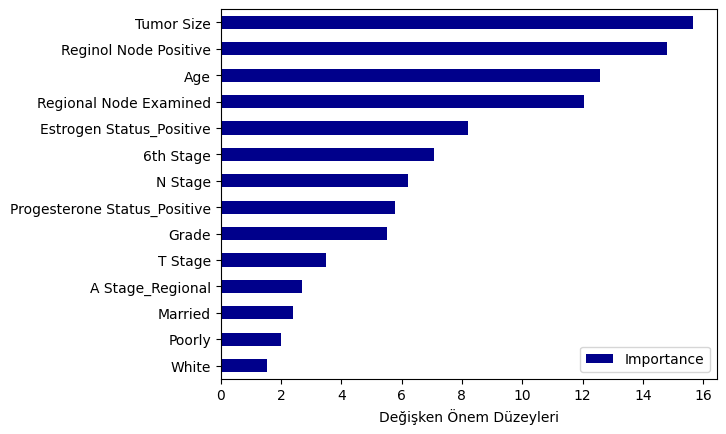

In [54]:
Importance.sort_values(by="Importance",
                        axis=0, 
                        ascending=True).plot(kind="barh",color="darkblue")
plt.xlabel("Değişken Önem Düzeyleri")

! Bu kod, Random Forest regresyon modelinin özniteliklerinin önem sıralamasını belirlemek için kullanılır. feature_importances_ özelliği, her bir özniteliğin modelin tahmin yaparken ne kadar etkili olduğunu ölçen bir dizi döndürür.

#### Evaulation-RF

In [50]:
# Regresyon metriklerini hesaplayın
mse = mean_squared_error(y_test, y_pred_rf)
mae = mean_absolute_error(y_test, y_pred_rf)
r2 = r2_score(y_test, y_pred_rf)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R2): {r2:.4f}")

Mean Squared Error (MSE): 495.2575
Mean Absolute Error (MAE): 18.3218
R-squared (R2): 0.0570
